In [4]:
import random
import torch
from d2l import torch as d2l

In [5]:
dir(d2l)

['Accumulator',
 'AddNorm',
 'AdditiveAttention',
 'Animator',
 'AttentionDecoder',
 'BERTEncoder',
 'BERTModel',
 'BananasDataset',
 'Benchmark',
 'DATA_HUB',
 'DATA_URL',
 'Decoder',
 'DotProductAttention',
 'Encoder',
 'EncoderBlock',
 'EncoderDecoder',
 'F',
 'Image',
 'MaskLM',
 'MaskedSoftmaxCELoss',
 'MultiHeadAttention',
 'NextSentencePred',
 'PositionWiseFFN',
 'PositionalEncoding',
 'RNNModel',
 'RNNModelScratch',
 'RandomGenerator',
 'Residual',
 'SNLIDataset',
 'Seq2SeqEncoder',
 'SeqDataLoader',
 'Timer',
 'TokenEmbedding',
 'TransformerEncoder',
 'VOCSegDataset',
 'VOC_CLASSES',
 'VOC_COLORMAP',
 'Vocab',
 '_WikiTextDataset',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_get_batch_loss_bert',
 '_get_mlm_data_from_tokens',
 '_get_next_sentence',
 '_get_nsp_data_from_paragraph',
 '_pad_bert_inputs',
 '_read_wiki',
 '_replace_mlm_tokens',
 'abs',
 'accuracy',
 'annotate',
 'arange',
 'argmax',
 'assign_an

In [6]:
# synthetic_data:
# 输入：w,b,样本数量
# 输出：X(随机),y=Xw+b+噪声
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape(-1,1)

In [7]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print('随机生成的第一个样本：','\nfeatures:',features[0],'\nlabel:',labels[0])

随机生成的第一个样本： 
features: tensor([-0.1136, -1.0229]) 
label: tensor([7.4478])


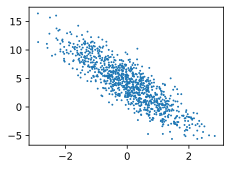

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
               labels.detach().numpy(),1);

In [9]:
# 每次读取一个小批量数据
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 将indices顺序打乱
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # batch_indices是一个向量
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [10]:
batch_size = 10
# 只打印第一次生成的小批量数据
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.2281, -0.5858],
        [ 1.3653,  0.7949],
        [-0.4115, -0.6100],
        [ 0.5047,  1.1488],
        [ 0.1528, -1.7215],
        [ 2.1504, -0.6740],
        [ 1.1831,  1.0924],
        [-1.5566,  0.7220],
        [ 0.6107, -0.0666],
        [-1.0422, -0.6956]]) 
 tensor([[ 5.7333],
        [ 4.2364],
        [ 5.4579],
        [ 1.3027],
        [10.3417],
        [10.7924],
        [ 2.8498],
        [-1.3804],
        [ 5.6632],
        [ 4.4863]])


In [11]:
# 定义模型参数
w = torch.normal(0,0.01,size=(2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

In [12]:
def linreg(X,w,b):
    '''定义线性回归模型'''
    return torch.matmul(X,w)+b

In [13]:
def squared_loss(y_hat,y):
    '''定义均方损失'''
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [18]:
def sgd(params,lr,batch_size):
    '''小批量随机梯度下降'''
    '''params:给定所有的参数，包括w和b'''
    '''lr:学习率'''
    with torch.no_grad():
        # param就两种情况：w，b
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()

In [20]:
lr = 0.03
num_epochs = 3
# linreg输入是输入X、权重w、偏差b，输出是预测的y_hat
net = linreg
# squared_loss输入是预测的y_hat，输出是y_hat与y的损失
loss = squared_loss

for epoch in range(num_epochs):
    # 每次随机取batch_size个数据（不重复）
    for X,y in data_iter(batch_size,features,labels):
        # 前向传播计算损失l，是一个列向量
        l = loss(net(X,w,b),y)
        # 计算梯度
        l.sum().backward()
        # 梯度下降
        sgd([w,b],lr,batch_size)
        
    with torch.no_grad():
        # features：所有样本
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 0.000138
epoch 2, loss 0.000053
epoch 3, loss 0.000053


In [21]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([1.9908e-05, 2.0432e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([9.7752e-05], grad_fn=<RsubBackward1>)
